In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta as ta
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

In [6]:
#Download SPY data from 1998 to 2023
spy = yf.download('SPY', start='2000-01-01', end='2010-01-01')

[*********************100%%**********************]  1 of 1 completed


In [7]:
#Calculate RSI for periods 2 to 24
rsi_columns = []
for i in range(2, 25):
    rsi_col = f'RSI_{i}'
    rsi_columns.append(rsi_col)
    spy[rsi_col] = ta.rsi(spy['Close'], length=i)

In [8]:
#Drop rows with NaN values (due to RSI calculation)
spy.dropna(inplace=True)

In [10]:
#Principal Component Analysis (PCA)
pca = PCA(n_components=6)
pca_data = pca.fit_transform(spy[rsi_columns])
lb = 6
#Least Squares Regression
model = LinearRegression()
X = pca_data[:-lb] #Exclude the last 6 rows for training
y = spy['Close'].pct_change(lb).dropna() #6-day ahead returns, shifted to align with X
model.fit(X, y)

LinearRegression()

In [11]:
#Predictions
pred = model.predict(pca_data) #Predict using all PCA data
pred = pred[lb-1:-lb] #Adjusted to align with the dates in X and y

In [12]:
#Align the Index for predictions with the corresponding dates in the original data
pred_dates = spy.index[lb-1:len(spy.index) - lb] #Adjusted to align with the dates in X and y

In [13]:
#Debugging: Check the lengths of pred_dates and pred
print(f"Length of pred_dates: {len(pred_dates)}")
print(f"Length of pred: {len(pred)}")

Length of pred_dates: 2480
Length of pred: 2480


In [14]:
#Store Predictions and signals in a DataFrame
predictions_df = pd.DataFrame({'Date':pred_dates, 'Prediction': pred})

In [29]:
#Thresholds
l_thresh = np.quantile(pred, 0.90)
s_thresh = np.quantile(pred, 0.10)

predictions_df['Signal'] = 0
predictions_df.loc[prediction_df['Prediction'] > l_thresh, 'Signal'] = 1
predictions_df.loc[prediction_df['Prediction'] < s_thresh, 'Signal'] = -1

NameError: name 'prediction_df' is not defined

In [21]:
#Aligning signals with daily returns
aligned_signals = predictions_df.set_index('Date')['Signal'].reindex(spy.index).fillna(0).shift(1) #Shift signals
daily_returns = spy['Close'].pct_change() #Daily returns of SPY
investment_returns = daily_returns * aligned_signals

In [22]:
#Fill NaN values in investment_returns with 0 
investment_returns.fillna(0, inplace=True)

In [23]:
#Calculate final investment value
investment = 10000 #Initial investment 
final_investment = investment * (1 + investment_returns).cumprod().iloc[-1]
print(f"Final investment value: ${final_investment:.2f}")

Final investment value: $10000.00


In [24]:
#Calculate cumulative returns
cumulative_returns = (1 + investment_returns).cumprod() - 1

In [25]:
#Calculate SPY's cumulative returns for comparison 
spy_cumulative_returns = (1 + spy['Close'].pct_change()).cumprod() - 1

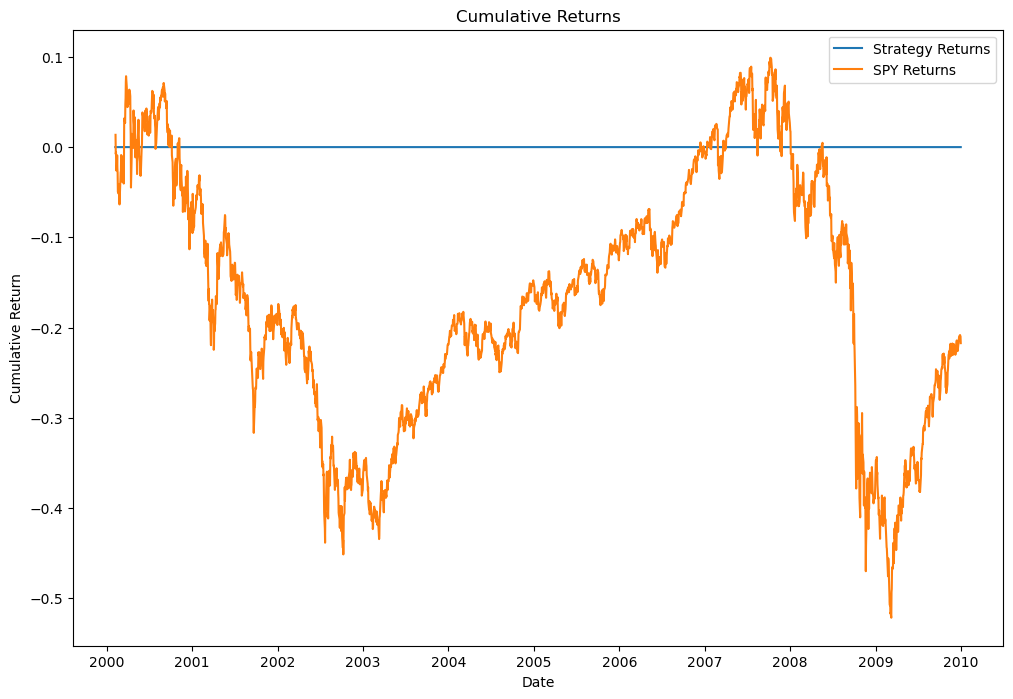

In [27]:
#Plot the cumulative returns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(cumulative_returns, label='Strategy Returns')
plt.plot(spy_cumulative_returns, label='SPY Returns')
plt.legend()
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()